# Compare genres of input and output books

In [1]:
import gensim
from gensim.models import Doc2Vec, KeyedVectors
import logging
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api # Downloading the Google pretrained Word2Vec Model

In [2]:
import numpy as np
import requests
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
import os
import json
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
import logging
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.metrics import multilabel_confusion_matrix
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from itertools import repeat

In [5]:
#read dataset
books_df = pd.read_csv('unique_books.csv')
#drop na (subset-genre)
books_df = books_df.dropna(subset=['genres'])
#remove quotes from around genre list
books_df['genres'] = books_df.loc[books_df['genres']!=np.nan, 'genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/4319 [00:00<?, ?it/s]

In [6]:
#create list of genres
genres_list = []
for i in books_df['genres']:
    genres_list.extend(i)
#create unique list of genres
unique_genres_list = sorted(list(set(genres_list)))
unique_genres_df = pd.DataFrame.from_dict({'genres': sorted(unique_genres_list)})
num_genres = len(unique_genres_list)
num_genres

423

In [7]:
counter=collections.Counter(genres_list)

In [8]:
counter.most_common(15)

[('Fiction', 2969),
 ('Fantasy', 2451),
 ('Romance', 1449),
 ('Young Adult', 1187),
 ('Mystery', 1059),
 ('Historical', 1042),
 ('Paranormal', 776),
 ('Science Fiction', 753),
 ('Contemporary', 641),
 ('Historical Fiction', 629),
 ('Classics', 609),
 ('Thriller', 587),
 ('Childrens', 482),
 ('Nonfiction', 480),
 ('Literature', 344)]

In [9]:
most_popular_genres_list = [value for value, count in counter.most_common(15)]
most_popular_genres_list

['Fiction',
 'Fantasy',
 'Romance',
 'Young Adult',
 'Mystery',
 'Historical',
 'Paranormal',
 'Science Fiction',
 'Contemporary',
 'Historical Fiction',
 'Classics',
 'Thriller',
 'Childrens',
 'Nonfiction',
 'Literature']

## Step 1: 
Original books genres -> matrix

In [42]:
#Read in recommendations as df
tfidf_recs_df = pd.read_csv('tfidf_recs_small.csv')

In [43]:
orig_book_indices = list(books_df.index)

In [44]:
num_orig_books = len(orig_book_indices)
num_orig_books

4319

In [51]:
recommended_books_df = tfidf_recs_df 
recommended_books_df.shape

(21595, 20)

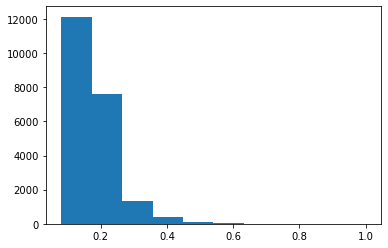

In [46]:
plt.hist(recommended_books_df['similarity_scores'])
plt.show()

In [53]:
#binarizer to transform between labels and a multilabel format
mlb = MultiLabelBinarizer()
#fit the binarizer to the list of genres
mlb.fit([sorted(unique_genres_list)])

MultiLabelBinarizer()

In [25]:
books_df.shape

(4319, 17)

In [26]:
num_preds_per_book = 5
orig_book_genres_matrix = []
for orig_book_index in orig_book_indices:
    orig_book = books_df.iloc[books_df.index==orig_book_index]
    orig_book_genres = orig_book['genres']
    orig_book_genres_matrix.extend(np.repeat(mlb.transform(orig_book_genres), repeats = num_preds_per_book, axis=0))

In [27]:
y_expected = np.array(orig_book_genres_matrix)

In [28]:
np.array(y_expected).shape

(21595, 423)

## Step 2
Predictions -> matrix with size = number of genres

In [29]:
#Cleaning: if genre = NaN, replace with '[]'
recommended_books_df.loc[recommended_books_df['genres'].isna(), 'genres']='[]'

In [30]:
recommended_books_df.shape

(21575, 20)

In [56]:
#Cleaning
#recommended_books = recommended_books.dropna(subset=['genres'])
recommended_books_df['genres'] = recommended_books_df['genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/21595 [00:00<?, ?it/s]

In [57]:
recommended_books_genres = list(recommended_books_df['genres'])


In [58]:
recommended_books_genres

[['Nonfiction', 'Psychology', 'Science', 'Sociology', 'Audiobook'],
 ['Humor', 'Nonfiction', 'Humor', 'Comedy'],
 ['Childrens', 'Fantasy', 'Fiction'],
 ['Childrens', 'Fiction', 'Fantasy'],
 ['Romance',
  'Paranormal Romance',
  'Paranormal',
  'Vampires',
  'Fantasy',
  'Paranormal',
  'Romance',
  'Fantasy'],
 ['Fiction', 'Mystery', 'Thriller'],
 ['Fantasy',
  'Science Fiction',
  'Fiction',
  'Science Fiction Fantasy',
  'Abandoned',
  'Classics',
  'Novels',
  'Speculative Fiction',
  'Apocalyptic',
  'Post Apocalyptic',
  'Epic'],
 ['Thriller', 'Fiction', 'Adventure', 'Mystery', 'Action'],
 ['Economics', 'Politics', 'Nonfiction', 'Philosophy', 'History'],
 ['Fantasy', 'Young Adult', 'Horror', 'Fiction'],
 ['Spirituality',
  'Self Help',
  'Nonfiction',
  'Philosophy',
  'Self Help',
  'Personal Development'],
 ['Business',
  'Nonfiction',
  'Leadership',
  'Business',
  'Management',
  'Self Help',
  'Self Help',
  'Personal Development',
  'Buisness',
  'Psychology',
  'Productivi

In [59]:
rec_books_matrix = mlb.transform(recommended_books_genres)

In [60]:
rec_books_matrix.shape

(21595, 423)

In [61]:
rec_books_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [62]:
#create dataframe to hold evaluation metrics
eval_metrics = pd.DataFrame(columns = ['precision', 'recall','f1score'])
eval_metrics['precision'] = np.zeros(num_genres)
eval_metrics['recall'] = np.zeros(num_genres)
eval_metrics['f1score'] = np.zeros(num_genres)

In [63]:
y_pred = rec_books_matrix
y_pred.shape

(21595, 423)

In [64]:
len_y_pred = len(y_pred)

In [65]:
#calculate metrics by genre
for i in range(rec_books_matrix.shape[1]):
    eval_metrics['precision'][i] = precision_score(y_expected[:,i], y_pred[:,i])
    eval_metrics['recall'][i] = recall_score(y_expected[:,i], y_pred[:,i])
    eval_metrics['f1score'][i] = f1_score(y_expected[:,i], y_pred[:,i])
    #matrix = multilabel_confusion_matrix(y_expected, y_pred)
    

/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:

In [66]:
eval_metrics

,precision,recall,f1score
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.181818,0.144000,0.160714
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
418,0.108108,0.100000,0.103896
419,0.000000,0.000000,0.000000
420,0.000000,0.000000,0.000000
421,0.000000,0.000000,0.000000


In [67]:
#check how many of the columns have value=1 for at least one

In [68]:
precision_weighted_average = precision_score(y_expected, y_pred, average='weighted', zero_division='warn')

/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([264.,  56.,  39.,  27.,  15.,  10.,   6.,   3.,   2.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

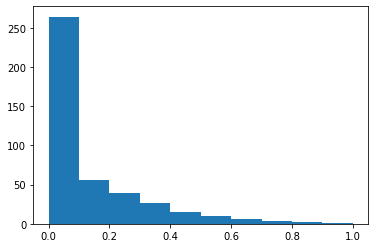

In [69]:
plt.hist(eval_metrics['precision'])

(array([259.,  51.,  45.,  23.,  30.,   8.,   4.,   0.,   2.,   1.]),
 array([0.        , 0.09166667, 0.18333333, 0.275     , 0.36666667,
        0.45833333, 0.55      , 0.64166667, 0.73333333, 0.825     ,
        0.91666667]),
 <BarContainer object of 10 artists>)

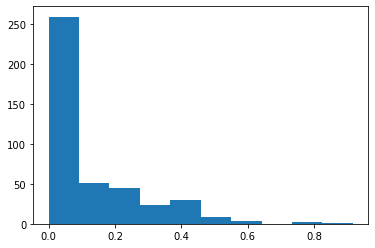

In [70]:
plt.hist(eval_metrics['recall'])

(array([247.,  54.,  36.,  38.,  18.,  18.,   5.,   4.,   0.,   3.]),
 array([0.        , 0.07971014, 0.15942029, 0.23913043, 0.31884058,
        0.39855072, 0.47826087, 0.55797101, 0.63768116, 0.7173913 ,
        0.79710145]),
 <BarContainer object of 10 artists>)

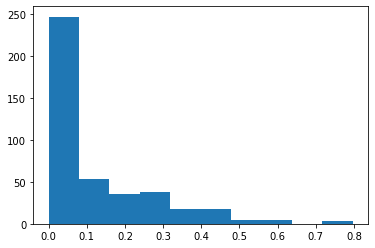

In [71]:
plt.hist(eval_metrics['f1score'])
    

In [72]:
print(classification_report(
    y_expected,
    y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        20
           2       0.18      0.14      0.16       125
           3       0.00      0.00      0.00        55
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        10
           6       0.02      0.03      0.02       175
           7       0.00      0.00      0.00        60
           8       0.00      0.00      0.00         5
           9       0.04      0.03      0.03       285
          10       0.22      0.28      0.25       185
          11       0.00      0.00      0.00        10
          12       0.08      0.10      0.09       520
          13       0.09      0.12      0.11       500
          14       0.26      0.28      0.27       915
          15       0.04      0.06      0.05       155
          16       0.10      0.08      0.09       150
          17       0.00    

/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
eval_metrics.iloc[unique_genres_list.index('Fiction'),:]

precision    0.798479
recall       0.756686
f1score      0.777021
Name: 151, dtype: float64

In [74]:
eval_metrics.iloc[unique_genres_list.index('Nonfiction'),:]

precision    0.408701
recall       0.555833
f1score      0.471045
Name: 273, dtype: float64

## Plot metrics for most popular genres

In [90]:
counter=collections.Counter(genres_list)
most_popular_genres_list = [value for value, count in counter.most_common(15)]
eval_metrics_pop = pd.DataFrame()
eval_metrics_pop.loc[:,'genre'] = most_popular_genres_list
eval_metrics_pop.loc[:,'precision']=''
eval_metrics_pop.loc[:,'recall']=''
eval_metrics_pop.loc[:,'f1score']=''
precision_list = []
for j in range(len(most_popular_genres_list)):
    genre = most_popular_genres_list[j]
    i = unique_genres_list.index(genre)
    eval_metrics_pop.iloc[j,1] = precision_score(y_expected[:,i], y_pred[:,i])
    eval_metrics_pop.iloc[j,2] = recall_score(y_expected[:,i], y_pred[:,i])
    eval_metrics_pop.iloc[j,3]= f1_score(y_expected[:,i], y_pred[:,i])
    

In [92]:
eval_metrics_pop.to_csv('eval_metrics_pop_tfidf_smalldataset.csv')

In [93]:
eval_metrics_pop

,genre,precision,recall,f1score
0,Fiction,0.798479,0.756686,0.777021
1,Fantasy,0.593627,0.604017,0.598777
2,Romance,0.561997,0.584372,0.572966
3,Young Adult,0.578373,0.48405,0.527024
4,Mystery,0.52827,0.431433,0.474966
5,Historical,0.357655,0.409105,0.381653
6,Paranormal,0.51373,0.520771,0.517227
7,Science Fiction,0.431107,0.365591,0.395656
8,Contemporary,0.361905,0.355694,0.358773
9,Historical Fiction,0.353269,0.38437,0.368164


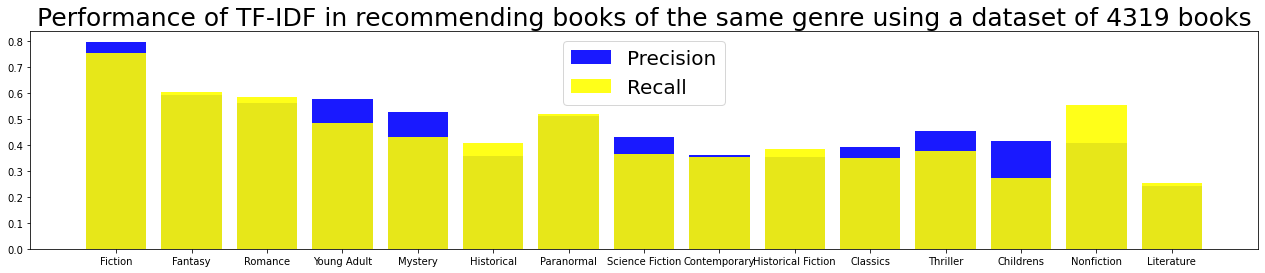

In [79]:
plt.figure(figsize=(22,4))
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_pop.precision, color = 'blue', alpha=0.9, label='Precision')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_pop.recall, color = 'yellow', alpha=0.9, label='Recall')
plt.legend(prop={'size': 20})
plt.title('Performance of TF-IDF in recommending books of the same genre using a dataset of 4319 books', size=25)
plt.savefig('tfidf_top_15_small_dataset_bar_chart.png')
plt.show()

## Comparison with random recommender

In [80]:
random_eval_metrics_df = pd.read_csv('eval_metrics_pop_random_smalldataset.csv')
random_eval_metrics_df = random_eval_metrics_df.iloc[:,1:]
random_eval_metrics_df = random_eval_metrics_df.rename(columns = {'precision': 'precision_random',
                                                                  'recall': 'recall_random',
                                                                 'f1score': 'f1score_random'})

In [87]:
random_eval_metrics_df.shape

(15, 4)

In [81]:
eval_metrics_pop =eval_metrics_pop.rename(columns = {'precision': 'precision_avg_word2vec',
                                                                  'recall': 'recall_avg_word2vec',
                                                                 'f1score': 'f1score_avg_word2vec'})
eval_metrics_comparison = pd.merge(eval_metrics_pop , random_eval_metrics_df, on = 'genre', how = 'inner')

In [82]:
eval_metrics_comparison

,genre,precision_avg_word2vec,recall_avg_word2vec,f1score_avg_word2vec,precision_random,recall_random,f1score_random
0,Fiction,0.798479,0.756686,0.777021,0.685933,0.689121,0.687523
1,Fantasy,0.593627,0.604017,0.598777,0.327599,0.322382,0.324969
2,Romance,0.561997,0.584372,0.572966,0.253484,0.253767,0.253626
3,Young Adult,0.578373,0.48405,0.527024,0.250223,0.251792,0.251005
4,Mystery,0.52827,0.431433,0.474966,0.163864,0.170793,0.167257
5,Historical,0.357655,0.409105,0.381653,0.160774,0.161457,0.161114
6,Paranormal,0.51373,0.520771,0.517227,0.118312,0.116488,0.117393
7,Science Fiction,0.431107,0.365591,0.395656,0.134622,0.134767,0.134695
8,Contemporary,0.361905,0.355694,0.358773,0.156592,0.151950,0.154236
9,Historical Fiction,0.353269,0.38437,0.368164,0.150854,0.152153,0.151501


### Precision:

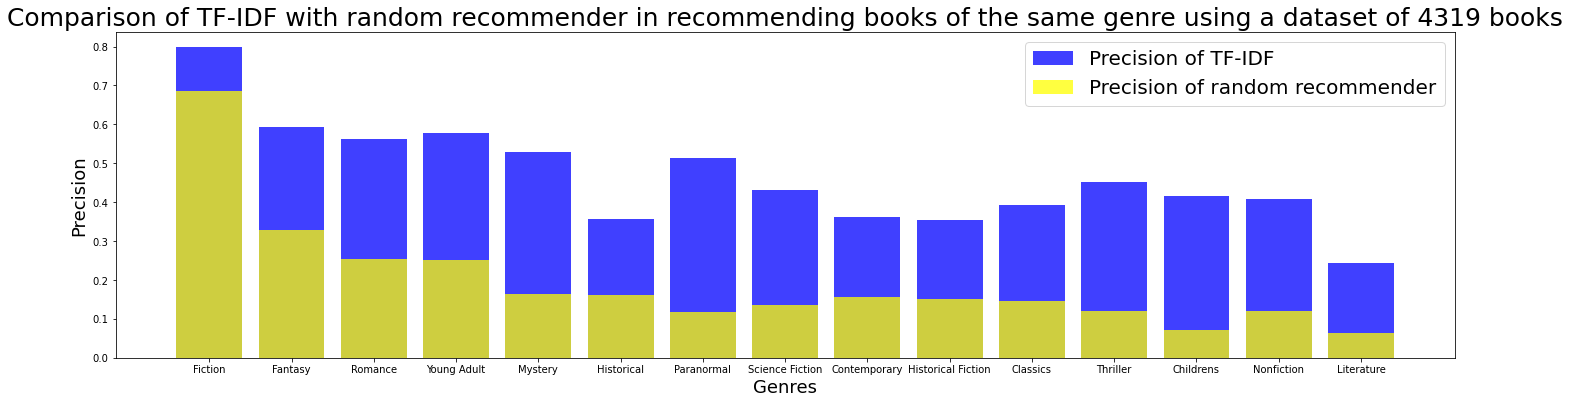

In [85]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.precision_avg_word2vec, color = 'blue', alpha=0.75, label='Precision of TF-IDF')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.precision_random, color = 'yellow', alpha=0.75, label='Precision of random recommender')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Precision', size=18)
plt.title('Comparison of TF-IDF with random recommender in recommending books of the same genre using a dataset of 4319 books', size=25)
plt.savefig('TFIDF_comparison_with_random_small_dataset_bar_chart_precision.png')
plt.show()

### Recall:

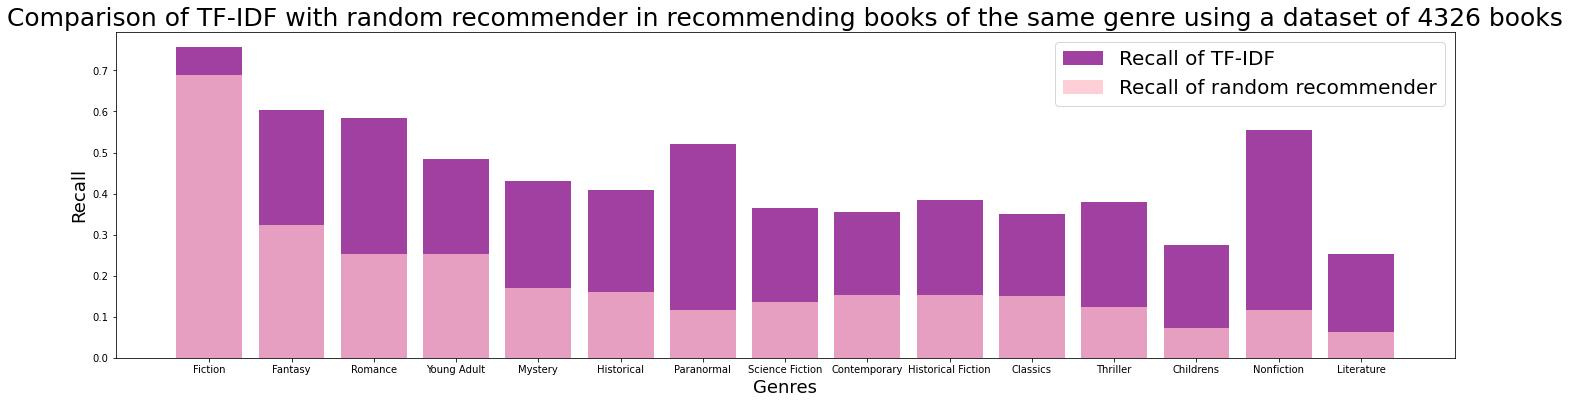

In [86]:
plt.figure(figsize=(24,6))
plt.bar(x=eval_metrics_comparison.genre, height = eval_metrics_comparison.recall_avg_word2vec, color = 'purple', alpha=0.75, label='Recall of TF-IDF')
plt.bar(x=eval_metrics_pop.genre, height = eval_metrics_comparison.recall_random, color = 'pink', alpha=0.75, label='Recall of random recommender')
plt.legend(prop={'size': 20})
plt.xlabel('Genres', size=18)
plt.ylabel('Recall', size=18)
plt.title('Comparison of TF-IDF with random recommender in recommending books of the same genre using a dataset of 4326 books', size=25)
plt.savefig('tfidf_comparison_with_random_small_dataset_bar_chart_recall.png')
plt.show()